# Project: Advanced Lane Finding 
---

## Objective:

The objective of this project is to create a pipeline with advanced computer vision techniques such as perspective transform, distortion calibration, color and gradient thresholding.

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

## Import Packages

In [1]:
# Importing Packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
%matplotlib inline

## An example image:

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


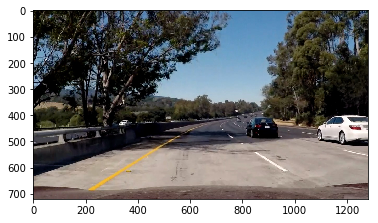

In [2]:
#reading in an image
road_image = mpimg.imread('test_images/test5.jpg')
# Pick 5 so that I can deal with the shadow

#printing out some stats and plotting
print('This image is:', type(road_image), 'with dimensions:', road_image.shape)
plt.imshow(road_image)  # plt.imshow(gray, cmap='gray') if grayscaled



# Calibrate Camera using Chessboard images taken (Undistort)


Text(0.5,1,'Undistorted Image')

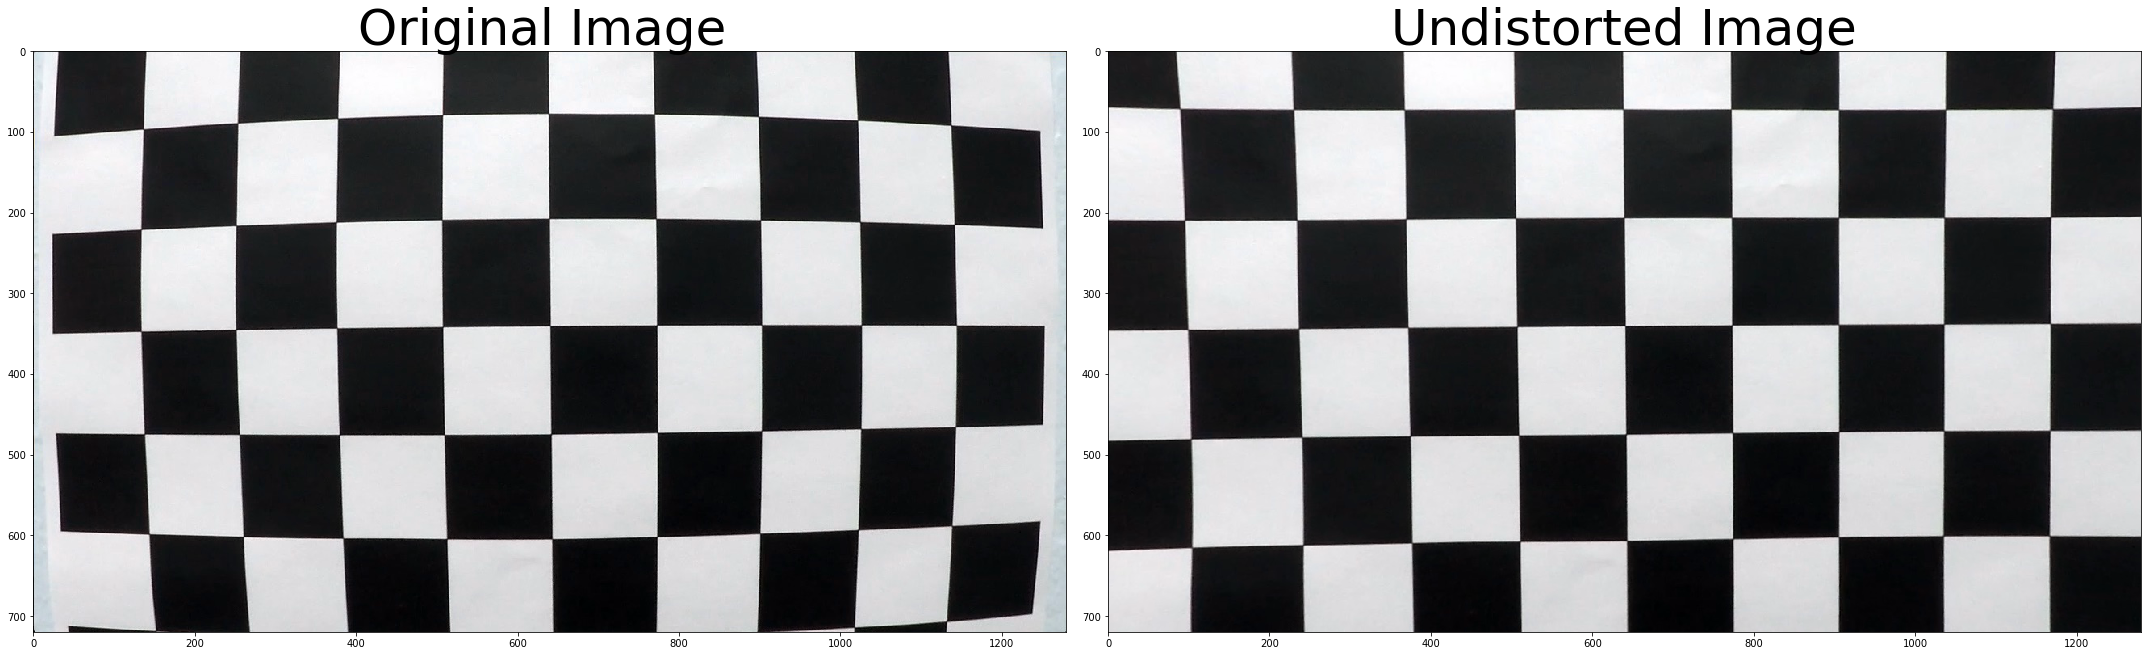

In [3]:
def calibrateCamera():
    # prepare object points
    nx = 9# number of inside corners in x
    ny = 6# number of inside corners in y

    # Empty array to store object and image points
    objpoints = []
    imgpoints = []

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, filename in enumerate(images):
            image = cv2.imread(filename)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

                #draw chessboard corners:
                cv2.drawChessboardCorners(image,(9,6),corners,ret)

    # Do camera calibration given object points and image points
    # Reference an image:
    img       = cv2.imread('camera_cal/calibration1.jpg')
    img_size  = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Savubg camera calibration parameters:
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle,open("camera_cal/calibration_pickle.p","wb"))

    
    return mtx,dist


# Undistort image
mtx,dist   = calibrateCamera()
img       = cv2.imread('camera_cal/calibration1.jpg')
undist_img = cv2.undistort(img, mtx, dist, None, mtx)

# Plotting:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image ', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=50)


File exist
File exist
File exist
File exist
File exist
File exist
File exist
File exist
File exist
File exist
File exist
File exist


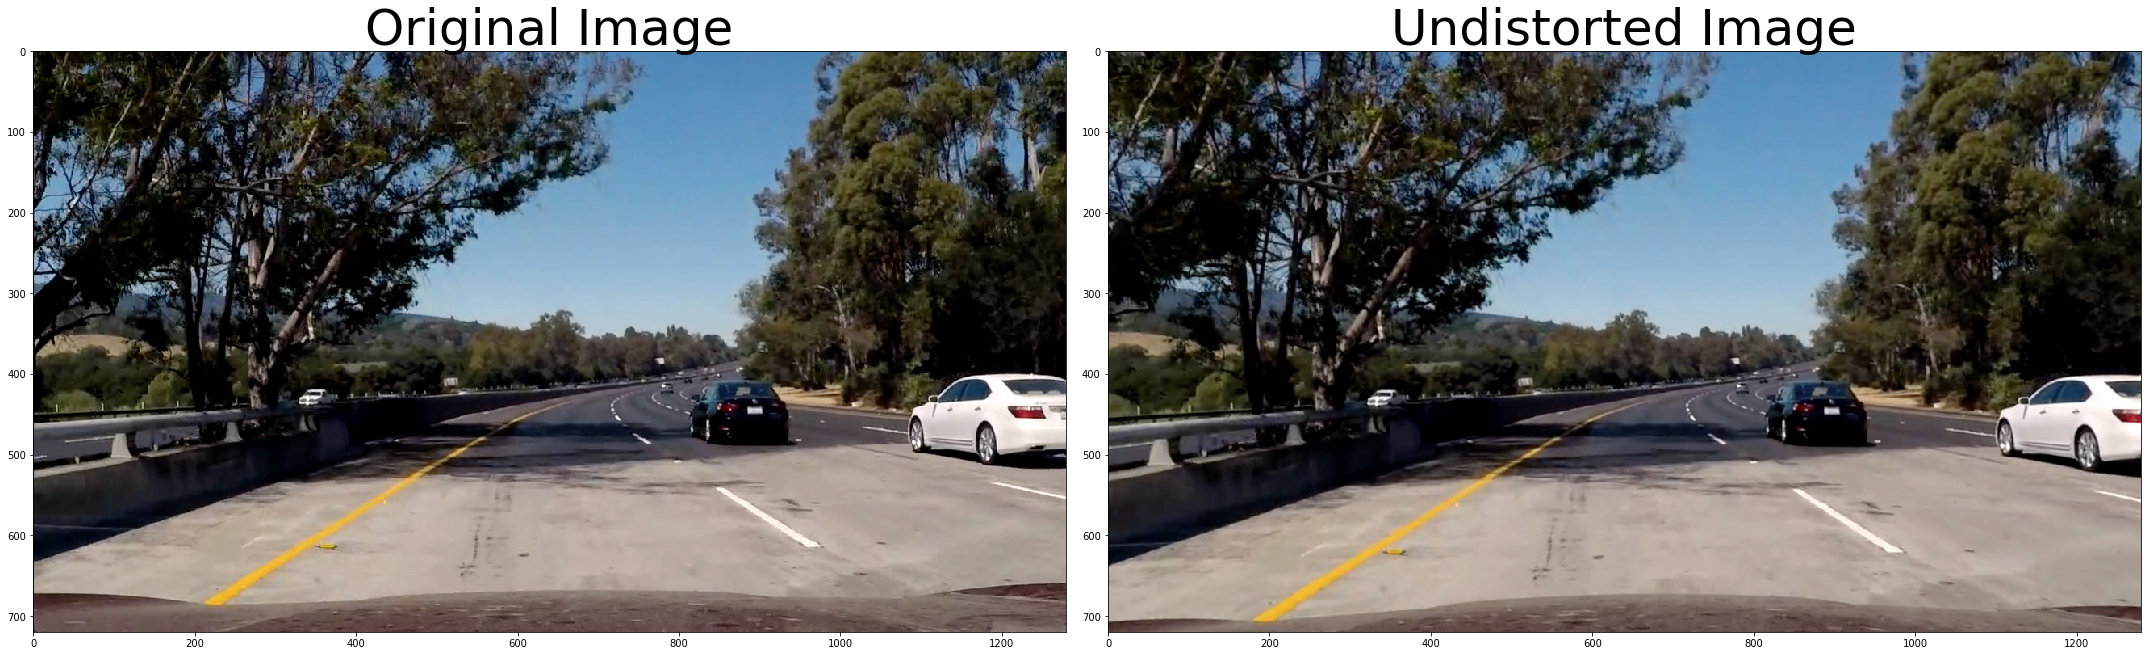

In [4]:
# Undistort  road image
undistorted_road = cv2.undistort(road_image, mtx, dist, None, mtx)
 
import os.path

# Plotting:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))
f.tight_layout()
ax1.imshow(road_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_road)
ax2.set_title('Undistorted Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Undistort all your test images

images = glob.glob('test_images/test*.jpg')

for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    result = img
   
    if os.path.isfile('test_images/test_undist'+str(idx)+'.jpg'):
        print ("File exist")
        # This prevents duplicating more into the file!
    else:
        write_name = 'test_images/test_undist'+str(idx)+'.jpg'
        cv2.imwrite(write_name,result)


# Color and Gradient Thresholding


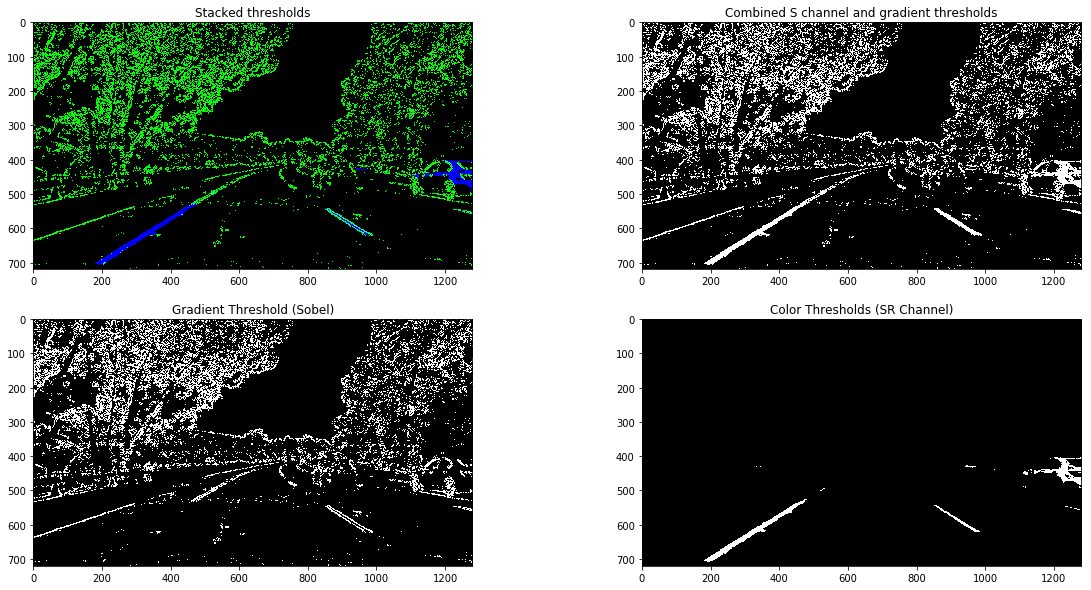

In [5]:
# Now let's go back to the road images.
# Reading in the undistorted image:
un_road_image = mpimg.imread('test_images/test_undist3.jpg') # Pick the shadow picture

#****************************************************************************
### Step 1: Sobel Operator (Gradient search and threshold)

## Sobel Operator for Gradient in direction x and y axis:
def abs_sobel_thresh(img, orient='x',sobel_kernel =3 , thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

## Sobel Operator for Gradient Magnitude
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


## Sobel Operator for Direction of Gradient
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run all of the sobel operators then combine all of the information!
def combine_grad(img):
    ksize = 3
    img   = cv2.GaussianBlur(img, (ksize, ksize), 0)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize,thresh=(10, 160))
    grady = abs_sobel_thresh(img, orient='y',sobel_kernel=ksize, thresh=(10, 160))
    #mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(50, 120))
    #dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.65, 1.1))

    combined_grad = np.zeros_like(gradx)
    #combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_grad[((gradx == 1) & (grady == 1))] = 1
    #combined_grad[(gradx == 1) ] = 1
    
    return combined_grad

# to combine all of the sobel operator:
combined_grad = combine_grad(un_road_image)

#*****************************************************************************

### Step 2: Color Space Selection and Threshold (Convert to HLS and select Saturation)

def color_threshold(img,thresh_min,thresh_max):
    
    R   = img[:,:,0]
    mini,maxi = 200,255

    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2] # Selecting the color space, Saturation (HLS)

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1
    
    r_binary = np.zeros_like(R)
    r_binary[(R>=mini) & (R<=maxi)] = 1
    

    
    return s_binary,r_binary

s_binary,r_binary = color_threshold(un_road_image,100,255)
sr_binary = np.zeros_like(s_binary)
sr_binary[(s_binary==1) & (r_binary==1)] = 1
#*****************************************************************************
### Step 3: Stack filters 



# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(combined_grad), combined_grad, sr_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(combined_grad)

combined_binary[(sr_binary == 1) | ((combined_grad == 1) & (r_binary ==1))
                | ((combined_grad == 1) & (s_binary ==1)) | combined_grad ==1] = 1


#*****************************************************************************
# Plotting and tuning the color channel/threshold/gradient threshold
fig, ax = plt.subplots(2, 2, figsize=(20,10))

ax[0,0].set_title('Stacked thresholds')
ax[0,0].imshow(color_binary)

ax[0,1].set_title('Combined S channel and gradient thresholds')
ax[0,1].imshow(combined_binary, cmap='gray')

ax[1,0].set_title('Gradient Threshold (Sobel)')
ax[1,0].imshow(combined_grad,cmap='gray') #Gradient Threshold Result


ax[1,1].set_title('Color Thresholds (SR Channel)')
ax[1,1].imshow(sr_binary,cmap='gray') #Color Space Threshold Result

fig.savefig('output_images/subplots.png') # save the figure to file


# Perspective Transform

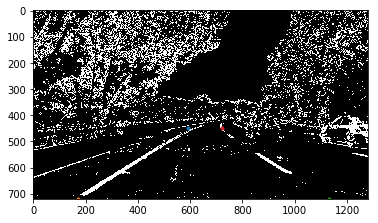

In [6]:
# With the combined binary image, we can do a perspective transform
# to obtain a bird-eye view. This view provides more important information
# for curves.
# 720, 1280
# Source Coordinate:

def warping(img):
    # source matrix
    src = np.array([[590, 450],
                    [170, 719],
                    [1130,719],
                    [720, 450]], dtype=np.float32)

    # target matrix to transform to
    dst = np.array([[200, 0],
                    [200, 720],
                    [1100, 720],
                    [1100, 0]], dtype=np.float32)

    img_size =(un_road_image.shape[1],un_road_image.shape[0])


    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped_image = cv2.warpPerspective(img, M, un_road_image.shape[1::-1],flags=cv2.INTER_LINEAR)
    
    return M,Minv,warped_image
# plotting to give better gauge of where to put the trapezoidal points

plt.imshow(combined_binary,cmap ='gray')
#plt.hold(True) 
plt.plot(590,450,'.')
plt.plot(170,719,'.')
plt.plot(1130,719,'.')
plt.plot(720,450,'.')


Text(0.5,1,'Bird-Eye View (Perspective Transformed)')

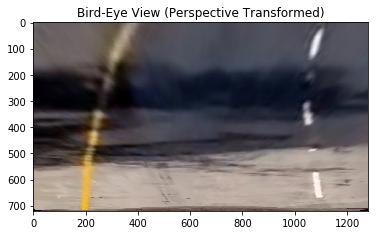

In [7]:
# Using this image to gauge dst and src coordinates
_,_,warped_image = warping(un_road_image)
plt.imshow(warped_image)
plt.title('Bird-Eye View (Perspective Transformed)')

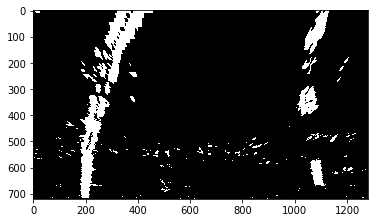

In [8]:
# Warped Image of the Binary Output from thresholding:
_,Minv,binary_warped = warping(combined_binary)
plt.imshow(binary_warped,cmap = 'gray')

# Can observe that the shadow disappears!

# Histrogram Peak (Finding starting point) and Sliding Window Function


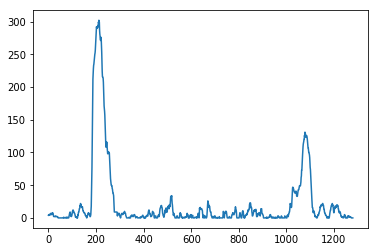

In [9]:
def get_histogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)

histogram = get_histogram(binary_warped)
plt.plot(histogram)

The left curve radius is 444.1149962888382m and right curve radius is 328.86397467181104m


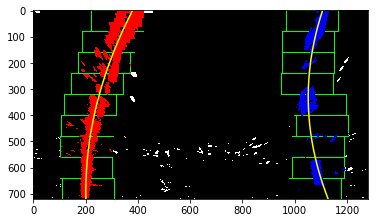

In [10]:
def find_lane(binary_warped):
    
    histogram = get_histogram(binary_warped)

    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin (note: width = margin * 2)
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # note, nonzero() returns is row-major, [0] =  row = y-axis
        # Therefore, we are finding the amount of nonzero pixels per y-axis(row) value 
        # within the bound of the sliding windows
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # FITING POLYNOMIAL**************************************************************************
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    #For finding curvature:************************************************************************
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    

    return out_img, ploty, left_fit, right_fit , left_fit_cr,right_fit_cr, left_curverad , right_curverad



x,ploty,left_fit,right_fit,left_fit_cr,right_fit_cr,left_curverad, right_curverad = find_lane(binary_warped)
# Plots the left and right polynomials on the lane lines
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(x)
        
print("The left curve radius is {}m and right curve radius is {}m".format(left_curverad,right_curverad))
                                                                                                           


# Annotating

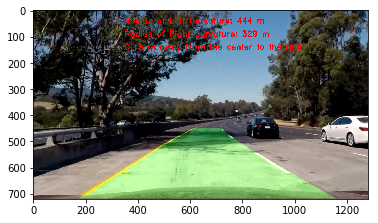

In [11]:
def drawLine(img,left_fit,right_fit,left_fit_cr,right_fit_cr,left_curverad,right_curverad,Minv):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
        
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #Calculate the center of the vehicle:
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    lineRight = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    awayFromCentre = lineMiddle - vehicleCenter
    if awayFromCentre > 0:
        message = '{:.2f} m away from the center to the right'.format(awayFromCentre)
    else:
        message = '{:.2f} m away from the center to the left'.format(awayFromCentre)    
    
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    draw = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Plotting:
    
    # Putting Text on Image:
    font = cv2.FONT_HERSHEY_DUPLEX
    text1 = "Radius of Left Curvature: {:.0f} m".format(left_curverad)
    text2 = "Radius of Right Curvature: {:.0f} m".format(right_curverad)
    text3 = message
    cv2.putText(draw,text1,(350,50), font, 1,(255,0,0),2)
    cv2.putText(draw,text2,(350,100), font, 1,(255,0,0),2)
    cv2.putText(draw,message,(350,150), font, 1,(255,0,0),2)  
    

    
    return draw

draw = drawLine(un_road_image,left_fit,right_fit,left_fit_cr,right_fit_cr,left_curverad,right_curverad,Minv)

plt.imshow(draw)

# Pipeline ( Putting all the functions together)

In [12]:
def pipeline(img):
    
    # STEP 1: Calibrate Camera 
    mtx,dist   = calibrateCamera()  # use chessboard images to calibrate the camera within the function
    
    # STEP 2: Undistort the input image of interest
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # STEP 3:  Gradient and Color Thresholding (Combined)
    
    # Note: Thresholding Function returns a binary image. 
    combined_grad = combine_grad(undist_img) # Gradient Thresholding (Sobel Operators)
    s_binary,r_binary = color_threshold(undist_img,100,255) # Color Thresholding (S channel of HLS)

    # Combined Color Binary:
    sr_binary = np.zeros_like(s_binary)
    sr_binary[(s_binary==1) & (r_binary==1)] = 1
    #***************************************************************************** 

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined_grad)

    combined_binary[(sr_binary == 1) | ((combined_grad == 1) & (r_binary ==1))
                    | ((combined_grad == 1) & (s_binary ==1)) | combined_grad ==1] = 1

    # STEP 4: Perspective Transform
    
    M,Minv,binary_warped = warping(combined_binary) # Warp the image that was filtered 
    
    
    # STEP 5: Find the lanes via sliding windows technique and fit polynomial
    
    # Note: Function also finds the curvature of the left and right lanes:
    _,_,left_fit,right_fit,left_fit_cr,right_fit_cr,left_curverad, right_curverad = find_lane(binary_warped)

    # STEP 6: Annotate
    
    return drawLine(img,left_fit,right_fit,left_fit_cr,right_fit_cr,left_curverad,right_curverad,Minv)
    
    
    

# Applying to Video

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
white_output = 'test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [1:23:29<00:03,  3.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 1h 20min 10s, sys: 39.3 s, total: 1h 20min 49s
Wall time: 1h 23min 33s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

#Note that left curvature is giving logical values all the time while the right is not,
# this is because the right curvature is broken up and sometimes it does not get detected

In [ ]:
# Shadow problem is fixed from first submission :)